In [1]:
!pip install numpy
!pip install matplotlib
!pip install graphviz


  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.
  Using cached matplotlib-3.8.3-cp39-cp39-macosx_11_0_arm64.whl (7.5 MB)
  Using cached pillow-10.2.0-cp39-cp39-macosx_11_0_arm64.whl (3.3 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached fonttools-4.49.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl (66 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.2.0-cp39-cp39-macosx_11_0_arm64.whl (242 kB)
  Using cached importlib_resources-6.1.1-py3-none-any.whl (33 kB)
You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
You should consider upgrading via the '/Users/nikasak

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return x**2 + 2*x

In [4]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)

120

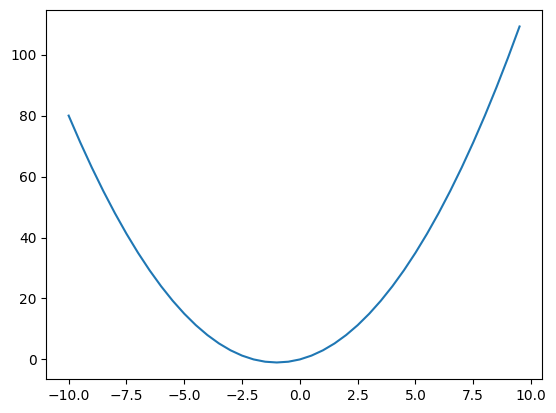

In [5]:
plt.plot(xs, ys)
f(10)

In [6]:
h = 0.000000000001
x = 3.0
y = f(x)
(f(x + h) - f(x))/h

8.000711204658728

In [39]:
class Value:
    def __init__(self, value, _children=(), _op="", label=""):
        self.data = value
        self.grad = 0.0
        self._backward  = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        val = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * val.grad
            other.grad += 1 * val.grad
        val._backward = _backward
        return val
    
    def backward(self):
        def backward_helper(node):
            if node is not None:
                node._backward()
                for child in node._prev:
                    backward_helper(child)
        backward_helper(self)
    
    def __mul__(self, other):
        val = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += val.grad * other.data
            other.grad += val.grad * self.data
        val._backward = _backward
        return val

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)        
        val = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * val.grad
        val._backward = _backward
        return val
    
    

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

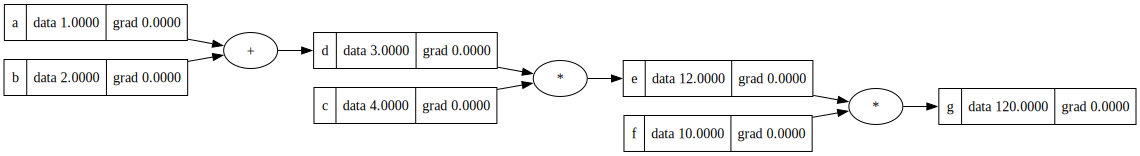

In [9]:
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(4, label='c')
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
f = Value(10, label='f')
g = e * f; g.label = 'g'
draw_dot(g)


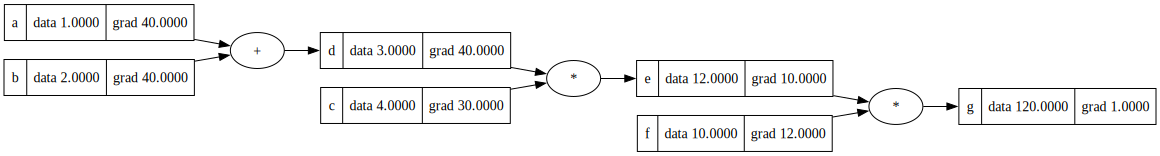

In [10]:
h = 0.0001
def manual_grad_calc():
    
    def getOutput(increased=False, varName=None):
        if increased and not varName:
            raise Exception('increased and varName must be present both or none')
        a = Value(1 + h if increased and varName == 'a' else 1, label='a')
        b = Value(2 + h if increased and varName == 'b' else 2, label='b')
        c = Value(4 + h if increased and varName == 'c' else 4, label='c')
        d = a + b
        if increased and varName == 'd':
            d.data += h
        d.label = 'd'
        e = (d * c)
        if increased and varName == 'e':
            e.data += h
        e.label = 'e'
        f = Value(10 + h if increased and varName == 'f' else 10, label='f')
        g = e * f
        if increased and varName == 'g':
            g.data += h
        g.label = 'g'
        

        return g
    
    result = {}
    
    for var in ['e', 'f', 'g']:
        raised = getOutput(True, var)
        original = getOutput()
        grad = (raised.data - original.data) / h
        result[var] = grad
    return result

grads = manual_grad_calc()


# Gradients for these variables don't need to use chain rule from calculus
e.grad = grads['e']
f.grad = grads['f']
g.grad = grads['g']

# dg/dc  needs to use chain rule = dg/de * de/dc = 10 * 3 = 30
c.grad = 30

# dg/dd  needs to use chain rule = dg/de * de/dd = 10 * 3 = 30
d.grad = 40

# dg/db needs to use chain rule = dg/de * de/dd * dd/db = 10 * 4 * 1 = 400
b.grad = 40

# da/db needs to use chain rule = dg/de * de/dd * dd/da = 10 * 4 * 1 = 40
a.grad = 40

# results for a and b being same as for d is intuitive since plus sign simply distributed the gradient of the parent

draw_dot(g)

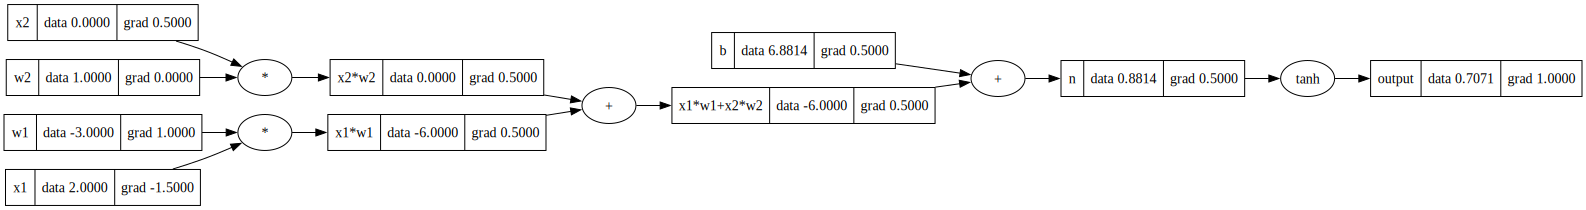

In [40]:
# Basic Neuron

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1' 
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = 'output'

output.grad = 1.0
output.backward()



draw_dot(output)

